In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import numpy as np

import cv2

import skimage
from skimage import io, transform, feature, color, exposure, draw

from sklearn import svm, model_selection, metrics, dummy

from pasuryan.datasets import colorferet
from pasuryan.improc import filters
from pasuryan.powerup import indextra
from pasuryan.feature import hog

from matplotlib import pyplot as plt



In [2]:
print("Loading colorferet data...")
clf_images = None
clf_targets = None

try:
    clf_images = np.load('.temp/clf_images.npy')
    clf_targets = np.load('.temp/clf_targets.npy')
    print("--loaded temp dataset--")
except:
    print("--build and save dataset--")
    clf_images, clf_targets = colorferet.load_data(label='gender', subset='smaller') # TODO add gender keyword, use images subset
    np.save('.temp/clf_images.npy', clf_images)
    np.save('.temp/clf_targets.npy', clf_targets)
# except:
    # pass

print(clf_images.shape, clf_targets.shape)
print("M:{}".format(np.sum(clf_targets)))
print("F:{}".format((clf_targets.size - np.sum(clf_targets))))
# print(clf_images.size, clf_targets.size)
# print(clf_images.dtype, clf_targets.dtype)
# print(clf_images.nbytes, clf_targets.nbytes)
print("... finish!! \^^/")


Loading colorferet data...
--loaded temp dataset--
(2722, 384, 256, 3) (2722,)
M:1715
F:1007
... finish!! \^^/


In [3]:
# WARNING large memory problem, use for loop.

# gamma correction
# clf_images = [exposure.adjust_gamma(x, gamma=10/22) for x in clf_images]

# convert to gray 
print("Converting to gray...")
clf_images_bw = None

try:
    clf_images_bw = np.load('.temp/clf_images_bw.npy')
    print("--loaded temp bw images--")
except:
    print("--build and save bw images--")
    ## ITU-R 601-2 luma transform (PIL.Image.convert('L'))
    ## L = R * 0.299  + G * 0.587   + B * 0.114
    _Lcoef = np.array([0.299,0.587,0.114])
    ## CRT transform (skimage.color.rgb2gray())
    ## L = R * 0.2125 + G * 0.7154  + B * 0.0721 
    # _Lcoef = np.array([0.2125,0.7154,0.0721])
    ## equal value
    ## L = ( R + G + B ) / 3
    # _Lcoef = np.array([1/3]*3)
    clf_images_bw = [ np.sum(_Lcoef[None,None,:]*img, axis=-1).astype('uint8') for img in clf_images ]
    np.save('.temp/clf_images_bw.npy', clf_images_bw)
    
print("... done! XD")


Converting to gray...
--loaded temp bw images--
... done! XD


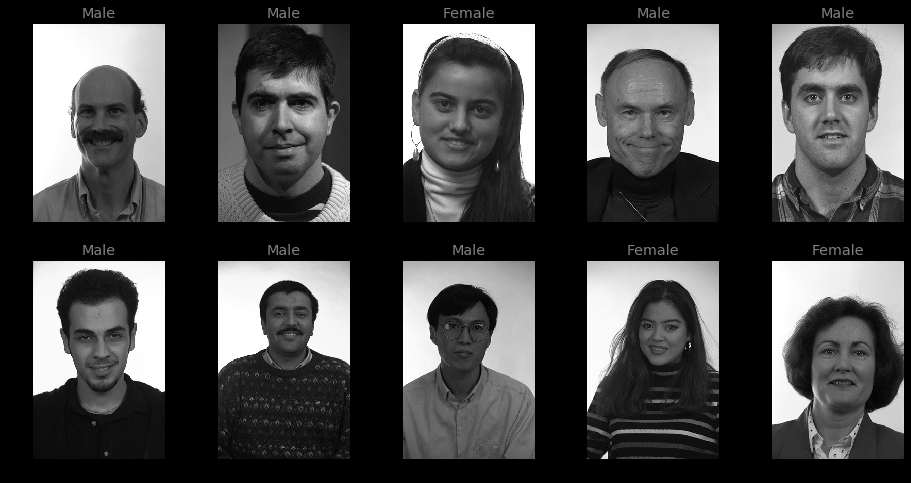

In [4]:
show_size = (2,5)

sample_ix = np.random.choice(len(clf_images_bw),show_size)
f, axs = plt.subplots(*show_size, figsize=(16,8))
# print((len(axs)))
# ax[0].imshow(clf_images_bw[sample_ix[0]])
# ax[1].imshow(clf_images_bw[sample_ix[1]])
for i, ax in np.ndenumerate(axs):
    ax.imshow(clf_images_bw[sample_ix[i]], cmap='gray')
    ax.axis('off')
    ax.set_title('Female' if clf_targets[sample_ix[i]] == 0 else 'Male', color='gray', fontsize='x-large')



In [5]:
def get_only_faces(faceCascades, img, _rz_factor=1, attempt_index=0):
    try:
        facepos = faceCascades[attempt_index].detectMultiScale(img,1.1)
        x,y,w,h = facepos[0]
        w = int(w*_rz_factor)
        h = int(h*_rz_factor)
        #found face!
        # roi_face = img[y:y+h, x:x+w]
        return x, y, w, h
    except:
        if attempt_index < len(faceCascades):
            return get_only_faces(faceCascades, img, _rz_factor, attempt_index+1)
        else:
            # print(attempt_index)
            return 0, 0, 0, 0

#Windows
_prefix_ = "A:\ProgramData\Anaconda3\envs\pencit\Library\etc\haarcascades"
#Linux
# _prefix_ = "/media/otivedani/Alpha/~linux/anaconda3/envs/pencit/share/OpenCV/haarcascades/"

faceCascades = [cv2.CascadeClassifier(_prefix_+_) for _ in ["\haarcascade_frontalface_default.xml", "\haarcascade_frontalface_alt.xml","\haarcascade_frontalface_alt2.xml","\haarcascade_frontalface_alt_tree.xml"]]
faceCascades += [cv2.CascadeClassifier(_prefix_+"\..\lbpcascades"+_) for _ in ["lbpcascade_frontalface_improved.xml", "lbpcascade_frontalface.xml"]]

face_rects = np.array([ get_only_faces(faceCascades, val) for val in clf_images_bw ])
is_face_found = np.all(face_rects, axis=1) != 0


In [6]:

face_imgs, face_targets, noface_imgs, noface_targets = [],[],[],[]
# rzd_face_imgs, rzd_noface_imgs = [],[]

try:
    face_imgs, face_targets, noface_imgs, noface_targets = np.load('.temp/face_noface_imgs.npy', allow_pickle=True)
    print("--loaded temp bw face images--")
except:
    print("--build and save bw face images--")
    
    noface_imgs = clf_images_bw[np.where(~is_face_found)]
    tmp_face_imgs = [ img[y:y+h, x:x+w] for img, (x, y, w, h) in zip(clf_images_bw[np.where(is_face_found)], face_rects[np.where(is_face_found)])]

    noface_targets = clf_targets[np.where(~is_face_found)]
    face_targets = clf_targets[np.where(is_face_found)]

    # print(np.amax(face_rects, axis=0))
    max_x, max_y, max_w, max_h = np.amax(face_rects, axis=0)
    #make all face same size
    #use CV
    face_imgs   = [ cv2.resize(fimg,(max_w,max_h)) for fimg in tmp_face_imgs ]
    # noface_imgs = [ cv2.resize(fimg,(max_w,max_h)) for fimg in tmp_noface_imgs ]
    # #use skimage
    # rzd_face_imgs   = [ transform.resize(fimg,(max_h,max_w)) for fimg in face_imgs ]
    # rzd_noface_imgs = [ transform.resize(fimg,(max_h,max_w)) for fimg in noface_imgs ]

    np.save('.temp/face_noface_imgs.npy', (face_imgs, face_targets, noface_imgs, noface_targets))

print("faces : ",len(face_imgs), len(face_targets) )
print("no face : ",len(noface_imgs), len(noface_targets) )
print("...done resizing too!")


--loaded temp bw face images--
faces :  2721 2721
no face :  1 1
...done resizing too!


In [7]:

print()

254 382 6 4


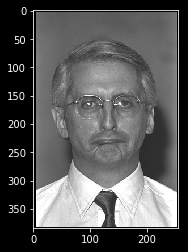

In [8]:
sample_idx = 0

_ptmax, _ptmin = np.amax((face_rects[:,:-2]+face_rects[:,2:]), axis=0), np.amin(face_rects[np.where(is_face_found)][2:], axis=0)
# print(_ptmax,_ptmin)
# print(np.amax((face_rects[:,:-2]+face_rects[:,2:]), axis=0), np.amin(face_rects[np.where(is_face_found)], axis=0)[2:])
(_aoe_tr, _aoe_br), (_aoe_tl, _aoe_bl) = np.amax((face_rects[:,:-2]+face_rects[:,2:]), axis=0), np.amin(face_rects[np.where(is_face_found)], axis=0)[:-2]
print(_aoe_tr, _aoe_br, _aoe_tl, _aoe_bl)
# _pts = np.array([_ptmin[0], _ptmin[1], _ptmax[0], _ptmax[1]])
# _ixr = np.array([[0,2,2,0,0], [3,3,1,1,3]])
# face_sample_img = clf_images_bw[sample_idx].copy()

# _rr, _cc = draw.polygon(_pts[_ixr][1], _pts[_ixr][0], face_sample_img.shape)

# # f, axs = plt.subplots(1,3)
# # axs[0].imshow(clf_images_bw[sample_idx])
# # axs[1].imshow()
# # axs[2].imshow()

# _face_mask = np.zeros(face_sample_img.shape)
# _face_mask[_rr,_cc] = 0.3
# face_sample_img = np.multiply(face_sample_img,_face_mask)
face_sample_img = clf_images_bw[sample_idx]
_face_mask = np.zeros(face_sample_img.shape)
_face_mask[_aoe_bl:_aoe_br,_aoe_tl:_aoe_tr] = 0.3
plt.imshow(face_sample_img * _face_mask, cmap='gray')
plt.show()


In [9]:


# print()


In [10]:
max_h, max_w = face_imgs[0].shape

from pasuryan.misc import HOGparamSync
# numpy rodering nr,nc
HOGparamdict = {
    'wsz': (int(8*(max_h//8)), int(8*(max_w//8))),
    'ppc': (8, 8),
    'cpb': (1, 1),
    'bstride': (1, 1),
    'nbins': 9,
    'norm': 'L2',
    'vis': True
}

# Azzopardi, 2016 : winsize 128x128, cell 16x16, block 2x2, stride 1x1, 50:50
# Lemley, 2016 : winsize 51x51, cell 7x7, block 1x1, stride 1x1 70:30
# Lee, 2013 : winsize 128x128, cell 8x8, block 1x1, stride 1x1, 767:385

HOGparamSync.init_hogparam(HOGparamdict)
HOGparamSync.get_cv_hogparam('.temp/cv2HOGparam_face.yml')
_cv2HOGdesc = cv2.HOGDescriptor('.temp/cv2HOGparam_face.yml')

myHOGparam = HOGparamSync.get_my_hogparam()
skHOGparam = HOGparamSync.get_sk_hogparam()
print("initialized HOG parameter :\n" + str(HOGparamdict))


initialized HOG parameter :
{'wsz': (232, 232), 'ppc': (8, 8), 'cpb': (1, 1), 'bstride': (1, 1), 'nbins': 9, 'norm': 'L2', 'vis': True}


In [11]:
cv2hogs = []
skhogs = []
myhogs = []
myhogs_lq = []

myHOGparam_lq = myHOGparam.copy()
myHOGparam_lq['useInterpolation'] = not myHOGparam_lq['useInterpolation']

print("Build HOG features...")
for img in face_imgs:
# for i, img in enumerate(face_imgs):
    # print("[{}] <--".format(i), img.shape)
    #opencv
    cv2hog = np.array(_cv2HOGdesc.compute(img.T)).ravel()
    cv2hogs.append(cv2hog)

# for img in face_imgs: #disable this 'for' loop for building skhog / myhog using resized images
    #skhog
    skhog = skimage.feature.hog(img, **skHOGparam)
    skhogs.append(skhog)

    #myhog
    myhog = hog(img, **myHOGparam)
    myhogs.append(myhog)

    #myhog alt
    myhog_lq = hog(img, **myHOGparam_lq)
    myhogs_lq.append(myhog_lq)

# realitycheck
print('myhog_lq use interp =', myHOGparam_lq['useInterpolation'] != myHOGparam['useInterpolation'])

#show few samples
# raw_img_bw = np.array(clf_images_bw).reshape(len(clf_images_bw),-1).copy()

#try using unprocessed image
raw_myhogs = [ hog(img, **myHOGparam) for img in clf_images_bw ]

print("...build HOGs, done")

#===============================================================================================================================================================#

Build HOG features...
myhog_lq use interp = True
...build HOGs, done


In [12]:
# np.save('O:\.temp\hogs_8x8_4cpb.npy', (cv2hogs, skhogs, myhogs, myhogs_lq, raw_myhogs))
# cv2hogs, skhogs, myhogs, myhogs_lq, raw_myhogs = [], [], [], [], []
# cv2hogs, skhogs, myhogs, myhogs_lq, raw_myhogs = np.load('O:\.temp\hogs_8x8_1cpb.npy', allow_pickle=True)

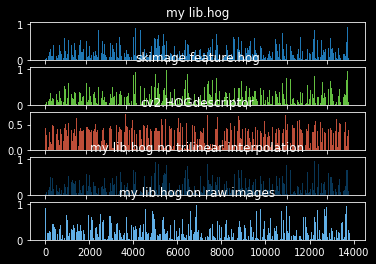

In [14]:
fig, axs = plt.subplots(5,1)
# ,constrained_layout=True
axs[0].bar(np.arange(myhogs[0].size),height=myhogs[0], color=[0.122, 0.467, 0.706, 1.0])
axs[0].set_title('my lib.hog')
axs[1].bar(np.arange(skhogs[0].size),height=skhogs[0], color=[0.388, 0.749, 0.251, 1.0])
axs[1].set_title('skimage.feature.hog')
axs[2].bar(np.arange(cv2hogs[0].size),height=cv2hogs[0], color=[0.737, 0.302, 0.22 , 1.0])
axs[2].set_title('cv2.HOGdescriptor')
axs[3].bar(np.arange(myhogs_lq[0].size),height=myhogs_lq[0], color=[0.03137,  0.21176,  0.33725, 1.0])
axs[3].set_title('my lib.hog no trilinear interpolation')
axs[4].bar(np.arange(raw_myhogs[0].size),height=raw_myhogs[0], color=[0.37647,  0.68235,  0.89804, 1.0])
axs[4].set_title('my lib.hog on raw images')
plt.show()


In [18]:

modelsets = (
    ('cv2 HOG - face', cv2hogs, face_targets),
    ('sklearn HOG - face', skhogs, face_targets),
    ('my HOG - face', myhogs, face_targets),
    ('my HOG - alt form', myhogs_lq, face_targets),
    ('my HOG - no face crop', raw_myhogs, clf_targets)
)

#comparing models
for i, (nama, in_X, in_Y) in enumerate(modelsets):
    print("------------------------------------------------------")
    # split train test data
    print("Using Feature : ", nama)

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
        in_X, in_Y, test_size=0.6, random_state=555 #or 555 or 123
    )

    print("\ntraining data: ")
    print(len(X_train), "F:{},M:{}".format(np.sum(Y_train==0),np.sum(Y_train==1)))
    print("\ntesting data: ")
    print(len(X_test), "F:{},M:{}".format(np.sum(Y_test==0),np.sum(Y_test==1)))
    print("------------------------------------------------------")
    
    # #Baseline performance
    # for strategy in ['stratified','most_frequent','prior','uniform','constant']:
    #     clf = dummy.DummyClassifier(strategy=strategy, random_state=23, constant=1)
    #     scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=3, scoring='accuracy')
    #     print("On %s," % (strategy))
    #     print("Accuracy: %0.2f (+/- %0.2f), lowest : %0.2f " % (scores.mean(), scores.std() * 2, scores.min()))

    # model check, overfit or not
    print("--Cross Validate on SVM...")
    clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
    scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f), lowest : %0.2f " % (scores.mean(), scores.std() * 2, scores.min()))
    # print("Accuracy: %0.2f (+/- %0.2f), lowest : %0.2f " % (scores.mean(), scores.std() * 2, scores.min()))
    
    #model training
    print("--Training in progress...")
    clf.fit(X_train, Y_train)
    pred_Y_test = clf.predict(X_test)
    
    print("--Test set--")
    print("Accuracy Score : " + str(metrics.accuracy_score(Y_test, pred_Y_test)))
    print("Precision Score : " + str(metrics.precision_score(Y_test, pred_Y_test, average="weighted")))
    print("Recall Score : " + str(metrics.recall_score(Y_test, pred_Y_test, average="weighted")))
    print("F1 Score : " + str(metrics.f1_score(Y_test, pred_Y_test, average="weighted")))
    print("Confusion Matrix : \n" + str(metrics.confusion_matrix(Y_test, pred_Y_test)))
    print("Report:\n", metrics.classification_report(Y_test, pred_Y_test, target_names=['Female','Male']))

    print("Finished~ \^^/")
    print("==============================================================","\n")


------------------------------------------------------
Using Feature :  cv2 HOG - face

training data: 
1088 F:395,M:693

testing data: 
1633 F:611,M:1022
------------------------------------------------------
--Cross Validate on SVM...
Accuracy: 0.93 (+/- 0.05), lowest : 0.90 
--Training in progress...
--Test set--
Accuracy Score : 0.9332516840171463
Precision Score : 0.9342985457023318
Recall Score : 0.9332516840171463
F1 Score : 0.9325242241412406
Confusion Matrix : 
[[528  83]
 [ 26 996]]
Report:
               precision    recall  f1-score   support

      Female       0.95      0.86      0.91       611
        Male       0.92      0.97      0.95      1022

   micro avg       0.93      0.93      0.93      1633
   macro avg       0.94      0.92      0.93      1633
weighted avg       0.93      0.93      0.93      1633

Finished~ \^^/

------------------------------------------------------
Using Feature :  sklearn HOG - face

training data: 
1088 F:395,M:693

testing data: 
1633 F:61

In [19]:

modelsets = (
    ('cv2 HOG - face', cv2hogs, face_targets),
    ('sklearn HOG - face', skhogs, face_targets),
    ('my HOG - face', myhogs, face_targets),
    ('my HOG - alt form', myhogs_lq, face_targets),
    ('my HOG - no face crop', raw_myhogs, clf_targets)
)

#comparing models
for i, (nama, in_X, in_Y) in enumerate(modelsets):
    print("------------------------------------------------------")
    # split train test data
    print("Using Feature : ", nama)

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
        in_X, in_Y, test_size=0.6, random_state=555 #or 555 or 123
    )

    print("\ntraining data: ")
    print(len(X_train), "F:{},M:{}".format(np.sum(Y_train==0),np.sum(Y_train==1)))
    print("\ntesting data: ")
    print(len(X_test), "F:{},M:{}".format(np.sum(Y_test==0),np.sum(Y_test==1)))
    print("------------------------------------------------------")
    
    # #Baseline performance
    # for strategy in ['stratified','most_frequent','prior','uniform','constant']:
    #     clf = dummy.DummyClassifier(strategy=strategy, random_state=23, constant=1)
    #     scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=3, scoring='accuracy')
    #     print("On %s," % (strategy))
    #     print("Accuracy: %0.2f (+/- %0.2f), lowest : %0.2f " % (scores.mean(), scores.std() * 2, scores.min()))

    # model check, overfit or not
    print("--Cross Validate on (Linear) SVM...")
    clf = svm.SVC(gamma='scale', decision_function_shape='ovo', kernel='linear')
    scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f), lowest : %0.2f " % (scores.mean(), scores.std() * 2, scores.min()))
    # print("Accuracy: %0.2f (+/- %0.2f), lowest : %0.2f " % (scores.mean(), scores.std() * 2, scores.min()))
    
    #model training
    print("--Training in progress...")
    clf.fit(X_train, Y_train)
    pred_Y_test = clf.predict(X_test)
    
    print("--Test set--")
    print("Accuracy Score : " + str(metrics.accuracy_score(Y_test, pred_Y_test)))
    print("Precision Score : " + str(metrics.precision_score(Y_test, pred_Y_test, average="weighted")))
    print("Recall Score : " + str(metrics.recall_score(Y_test, pred_Y_test, average="weighted")))
    print("F1 Score : " + str(metrics.f1_score(Y_test, pred_Y_test, average="weighted")))
    print("Confusion Matrix : \n" + str(metrics.confusion_matrix(Y_test, pred_Y_test)))
    print("Report:\n", metrics.classification_report(Y_test, pred_Y_test, target_names=['Female','Male']))

    print("Finished~ \^^/")
    print("==============================================================","\n")


------------------------------------------------------
Using Feature :  cv2 HOG - face

training data: 
1088 F:395,M:693

testing data: 
1633 F:611,M:1022
------------------------------------------------------
--Cross Validate on (Linear) SVM...
Accuracy: 0.94 (+/- 0.05), lowest : 0.91 
--Training in progress...
--Test set--
Accuracy Score : 0.9491733006736068
Precision Score : 0.9492956731338572
Recall Score : 0.9491733006736068
F1 Score : 0.9489110583186391
Confusion Matrix : 
[[555  56]
 [ 27 995]]
Report:
               precision    recall  f1-score   support

      Female       0.95      0.91      0.93       611
        Male       0.95      0.97      0.96      1022

   micro avg       0.95      0.95      0.95      1633
   macro avg       0.95      0.94      0.95      1633
weighted avg       0.95      0.95      0.95      1633

Finished~ \^^/

------------------------------------------------------
Using Feature :  sklearn HOG - face

training data: 
1088 F:395,M:693

testing data: 
